In [1]:
#basic
import pandas as pd
import numpy as np

#plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.3)
plt.style.use("fivethirtyeight")
%matplotlib inline


# For reading stock data 
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

#for evaluation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

#for modeling
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

np.random.seed(123)

## Load Data

In [2]:
df = DataReader('AAL', data_source='yahoo', start='2012-01-01', end=datetime.now())
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,5.220000,5.070000,5.200000,5.120000,6105900.0,4.826837
2012-01-04,5.180000,4.970000,5.090000,5.030000,5268700.0,4.741990
2012-01-05,5.480000,5.070000,5.150000,5.470000,8216100.0,5.156795
2012-01-06,5.670000,5.400000,5.440000,5.600000,8323000.0,5.279352
2012-01-09,5.800000,5.550000,5.560000,5.720000,8029900.0,5.392481
...,...,...,...,...,...,...
2021-09-02,19.980000,19.480000,19.730000,19.760000,20179400.0,19.760000
2021-09-03,19.930000,19.320000,19.680000,19.370001,20311900.0,19.370001
2021-09-07,19.650000,19.209999,19.360001,19.530001,18291000.0,19.530001


## Data evaluation

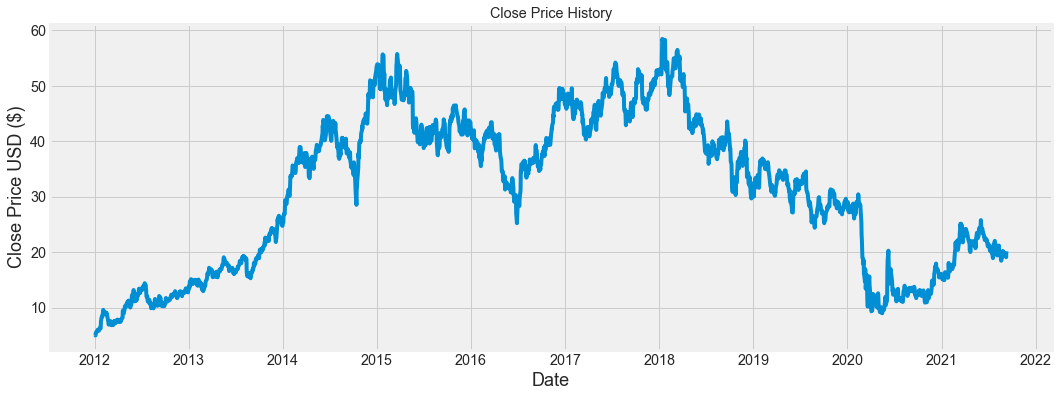

In [3]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

## Data preparation

In [4]:
# Create a new dataframe with only the 'Close column
#data= AAPL['Close'].values.reshape(-1, 1)
data = df.filter(['Close'])
data

,Close
Date,
2012-01-03,5.120000
2012-01-04,5.030000
2012-01-05,5.470000
2012-01-06,5.600000
2012-01-09,5.720000
...,...
2021-09-02,19.760000
2021-09-03,19.370001
2021-09-07,19.530001


In [5]:
# Convert the dataframe to a numpy array
dataset = data.values

In [6]:
dataset.shape

(2438, 1)

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


In [8]:
training_data_len = int(np.ceil( len(dataset) * .9 ))
train_data = scaled_data[0:int(training_data_len), :]

In [9]:
train_data.shape

(2195, 1)

In [10]:
def train_val(data):
    train_size = int(len(data) * 0.8)
    train = data[0:train_size]
    val= data[train_size:len(data)]
    return train, val

In [11]:
train_1, val_1 = train_val(train_data)

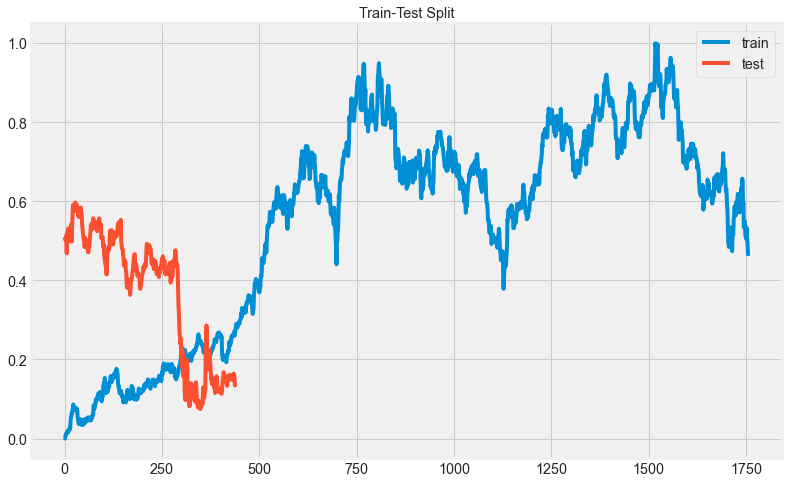

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_1, label='train')
ax.plot(val_1, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [13]:
#The LSTM needs data with the format of [samples, time steps and features]
#[10 20 30] 40
#[20 30 40] 50
#[30 40 50] 60
#using the size of time step as a batch to predict the next value 

def split_sequence(sequence, n_steps):
#convert input data into 3-D array as required for LSTM network
    
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [14]:
def prepare_training(data, n_steps):
    #data = to_dataset(data)
    train, val = train_val(data)
    x_train, y_train = split_sequence(train, n_steps)
    x_val, y_val = split_sequence(val, n_steps)
    features = 1
    return x_train, y_train, x_val, y_val, features


## Modeling

In [15]:

def creat_model1(n_steps, features):
    model = Sequential()
    model.add(LSTM(128, activation='relu', return_sequences=False, input_shape=(n_steps, features)))
    model.add(RepeatVector(n_steps))
    model.add(LSTM(128, activation='relu', return_sequences=False))
    model.add(Dense(features))
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [16]:
#including dropout layers

def creat_model2(n_steps, features):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model


In [17]:
#Bidirectional allows the model learn the input sequence both forward and backwards

def creat_model3(n_steps, features):
    model = Sequential()
    model.add(LSTM(200, input_shape=(n_steps, features)))
    model.add(RepeatVector(n_steps))
    model.add(Bidirectional(LSTM(200, activation='relu', return_sequences=False)))
    model.add(Dense(features))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [18]:
#Encoder-Decoder model

def creat_model4(n_steps, features):
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(n_steps, features), return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(RepeatVector(n_steps))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=False))
    model.add(Dense(features))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [19]:
n_steps = 10

x_train, y_train, x_val, y_val, feature = prepare_training(train_data,n_steps)

In [20]:
x_train.shape

(1746, 10, 1)

In [21]:
y_train.shape

(1746, 1)

In [22]:
#Stop training when a monitored metric has stopped improving.
early = EarlyStopping(monitor='val_loss',patience=5)

#Reduce learning rate when a metric has stopped improving.
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

## Test data set

In [23]:
test_data = scaled_data[training_data_len: , :]
x_test, y_test = split_sequence(test_data, n_steps)

In [24]:
y_test_re = scaler.inverse_transform(y_test)

In [25]:
y_test_re.shape

(233, 1)

## Model 1

In [26]:
model1 = creat_model1(n_steps, feature)

In [27]:
history1 = model1.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[early,reduce])

Epoch 1/50
35/35 [==============================] - 3s 42ms/step - loss: 0.1371 - mean_squared_error: 0.1371 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 2/50
35/35 [==============================] - 1s 25ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 7.4203e-04 - val_mean_squared_error: 7.4203e-04
Epoch 3/50
35/35 [==============================] - 1s 31ms/step - loss: 6.3168e-04 - mean_squared_error: 6.3168e-04 - val_loss: 7.2343e-04 - val_mean_squared_error: 7.2343e-04
Epoch 4/50
35/35 [==============================] - 1s 31ms/step - loss: 6.4575e-04 - mean_squared_error: 6.4575e-04 - val_loss: 6.8755e-04 - val_mean_squared_error: 6.8755e-04
Epoch 5/50
35/35 [==============================] - 1s 23ms/step - loss: 6.2299e-04 - mean_squared_error: 6.2299e-04 - val_loss: 6.5777e-04 - val_mean_squared_error: 6.5777e-04
Epoch 6/50
35/35 [==============================] - 1s 24ms/step - loss: 6.0705e-04 - mean_squared_error: 6.0705e-04 - val_loss: 7.3196e-04

In [28]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Get the models predicted price values 
predictions1 = model1.predict(x_test)

In [30]:
predictions1.shape

(233, 1)

In [31]:
predictions1 = scaler.inverse_transform(predictions1)

In [32]:
# Get the root mean squared error (RMSE)
##import math
#math.sqrt(mean_squared_error(y_test_re,predictions))
rmse1 = np.sqrt(np.mean(((predictions1 -y_test_re) ** 2)))
print(f'RMSE：{np.round(rmse1, 4)}')

RMSE：0.9083


## Model 2

In [33]:
model2 = creat_model2(n_steps, feature)

In [34]:
history2 = model2.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[early,reduce])

Epoch 1/50
35/35 [==============================] - 3s 36ms/step - loss: 0.0829 - mean_squared_error: 0.0829 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 2/50
35/35 [==============================] - 1s 19ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3/50
35/35 [==============================] - 1s 19ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 4/50
35/35 [==============================] - 1s 19ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 5/50
35/35 [==============================] - 1s 20ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 6/50
35/35 [==============================] - 1s 21ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 7/50
35/35 [================

In [35]:
predictions2 = model2.predict(x_test)

In [36]:
predictions2 = scaler.inverse_transform(predictions2)

In [37]:
rmse2 = np.sqrt(np.mean(((predictions2 -y_test_re) ** 2)))
print(f'RMSE：{np.round(rmse2, 4)}')

RMSE：1.1024


## Model 3

In [38]:
model3 = creat_model3(n_steps, feature)

In [39]:
history3 = model3.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[early,reduce])

Epoch 1/50
35/35 [==============================] - 5s 81ms/step - loss: 0.1061 - mean_squared_error: 0.1061 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 2/50
35/35 [==============================] - 2s 67ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 6.8076e-04 - val_mean_squared_error: 6.8076e-04
Epoch 3/50
35/35 [==============================] - 2s 58ms/step - loss: 6.5902e-04 - mean_squared_error: 6.5902e-04 - val_loss: 6.7292e-04 - val_mean_squared_error: 6.7292e-04
Epoch 4/50
35/35 [==============================] - 2s 61ms/step - loss: 6.7832e-04 - mean_squared_error: 6.7832e-04 - val_loss: 6.7211e-04 - val_mean_squared_error: 6.7211e-04
Epoch 5/50
35/35 [==============================] - 2s 66ms/step - loss: 6.1034e-04 - mean_squared_error: 6.1034e-04 - val_loss: 6.7716e-04 - val_mean_squared_error: 6.7716e-04
Epoch 6/50
35/35 [==============================] - 2s 66ms/step - loss: 5.9783e-04 - mean_squared_error: 5.9783e-04 - val_loss: 6.1596e-04

In [40]:
predictions3 = model3.predict(x_test)

In [41]:
predictions3.shape

(233, 1)

In [42]:
predictions3 = scaler.inverse_transform(predictions3)

In [43]:
rmse3 = np.sqrt(np.mean(((predictions3 -y_test_re) ** 2)))
print(f'RMSE：{np.round(rmse3, 4)}')

RMSE：0.8329


## Model 4

In [44]:
model4 = creat_model4(n_steps, feature)

In [45]:
history4 = model4.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[early,reduce])

Epoch 1/50
35/35 [==============================] - 4s 45ms/step - loss: 0.2148 - mean_squared_error: 0.2148 - val_loss: 0.0258 - val_mean_squared_error: 0.0258
Epoch 2/50
35/35 [==============================] - 1s 36ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3/50
35/35 [==============================] - 1s 34ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 4/50
35/35 [==============================] - 1s 34ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 5/50
35/35 [==============================] - 1s 35ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 6/50
35/35 [==============================] - 1s 35ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 7/50
35/35 [================

In [46]:
predictions4 = model4.predict(x_test)

In [47]:
predictions4 = scaler.inverse_transform(predictions4)

In [48]:
rmse4 = np.sqrt(np.mean(((predictions4 -y_test_re) ** 2)))
print(f'RMSE：{np.round(rmse4, 4)}')

RMSE：1.2138


## Plots

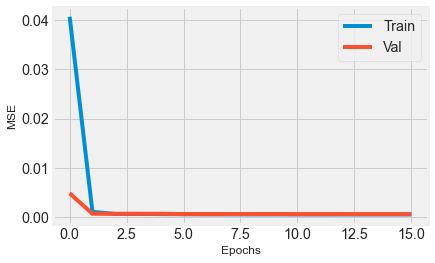

In [49]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

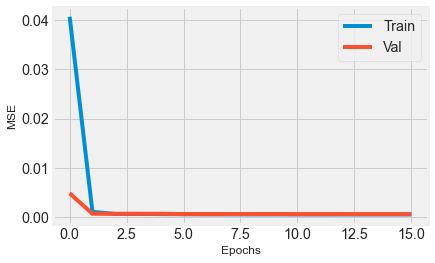

In [50]:
plt.plot(history3.history['mean_squared_error'])
plt.plot(history3.history['val_mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

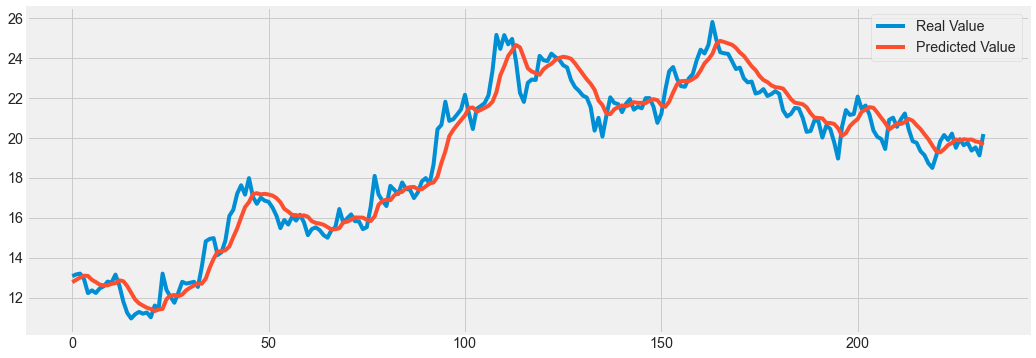

In [51]:
plt.figure(figsize=(16,6))
plt.plot(y_test_re)
plt.plot(predictions3)
plt.legend(['Real Value','Predicted Value']);

In [52]:
train = data[:training_data_len]
test = data[training_data_len+10:]

In [59]:
train

,Close
Date,
2012-01-03,5.12
2012-01-04,5.03
2012-01-05,5.47
2012-01-06,5.60
2012-01-09,5.72
...,...
2020-09-16,13.80
2020-09-17,13.63
2020-09-18,13.19


In [60]:
test

,Close,Predictions
Date,,
2020-10-07,13.070000,12.770354
2020-10-08,13.160000,12.889413
2020-10-09,13.200000,13.003885
2020-10-12,12.920000,13.095182
2020-10-13,12.220000,13.083738
...,...,...
2021-09-02,19.760000,19.913290
2021-09-03,19.370001,19.925795
2021-09-07,19.530001,19.830278


In [53]:
test.shape

(233, 1)

In [54]:
predictions3.shape

(233, 1)

In [55]:
test['Predictions'] = predictions3

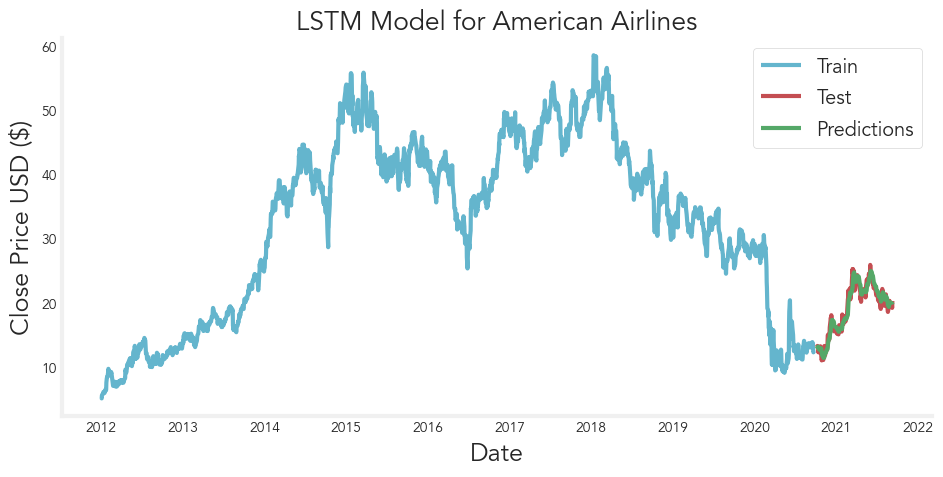

In [56]:
# Visualize the data

with plt.style.context('images/presentation.mplstyle'):
    plt.figure(figsize=(10,5), dpi=100)
    plt.title('LSTM Model for American Airlines')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'], 'c')
    plt.plot(test['Close'], 'r')
    plt.plot(test['Predictions'], 'g')
    plt.legend(['Train', 'Test', 'Predictions'], loc='upper right')
    #plt.savefig('images/LSTM.png')
    plt.show()
    
    

In [57]:
test

,Close,Predictions
Date,,
2020-10-07,13.070000,12.770354
2020-10-08,13.160000,12.889413
2020-10-09,13.200000,13.003885
2020-10-12,12.920000,13.095182
2020-10-13,12.220000,13.083738
...,...,...
2021-09-02,19.760000,19.913290
2021-09-03,19.370001,19.925795
2021-09-07,19.530001,19.830278
